In [11]:
import numpy as np
from PIL import Image as im

In [12]:
def read_binary_8bit_img_from_raw_data(filename, height, width):
    # Returns a numpy 2D array of 8bit integers representing image pixels
    # Open specified file
    with open(filename, "rb") as f:
        # Convert bytes read from file into a numpy array
        img = np.frombuffer(f.read(), dtype=np.ubyte)
        # This check is for images with some header, only raw bytes will be read, extra bytes will be sliced out
        if img.size > height * width:
            img = img[img.size-(height*width):]
        img = (img/img.max())
        return img.reshape((height, width)).astype(np.int32)

def write_binary_8bit_img_to_raw_data(img, filename):
    # Writes the argument numpy 2D array into a file by converting values into single bytes
    # Open Specified file
    img = img*255
    with open(filename, "wb") as f:
        # Write bytes into file
        f.write(img.astype(np.ubyte).tobytes())
        print("Image was written to {0}".format(filename))
        
def read_8bit_img_from_raw_data(filename, height, width):
    # Returns a numpy 2D array of 8bit integers representing image pixels
    # Open specified file
    with open(filename, "rb") as f:
        # Convert bytes read from file into a numpy array
        img = np.frombuffer(f.read(), dtype=np.ubyte)
        # This check is for images with some header, only raw bytes will be read, extra bytes will be sliced out
        if img.size > height * width:
            img = img[img.size-(height*width):]
        return img.reshape((height, width)).astype(np.int32)

def write_8bit_img_to_raw_data(img, filename):
    # Writes the argument numpy 2D array into a file by converting values into single bytes
    # Open Specified file
    with open(filename, "wb") as f:
        # Write bytes into file
        f.write(img.astype(np.ubyte).tobytes())
        print("Image was written to {0}".format(filename))
        
def pad(img, padding=2, mode='zeros'):
    padded = np.zeros((img.shape[0]+padding*2, img.shape[1]+padding*2), dtype=np.ubyte)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            padded[i+padding][j+padding] = img[i][j]
    return padded

def normalize(img, ceil=255):
    # Returns a normalized version of the argument numpy 2D array
    # Checks if the image is already normalized
    if img.min() < 0 or img.max() > ceil:
        # Copy the input image
        normalized_img = img.copy().astype(np.float32)
        # Subtract the minimum of the input image
        normalized_img = normalized_img - img.min()
        # Multiplication of ceil to the ratios of the image pixels with respect to the image maximum
        normalized_img = (ceil * normalized_img / normalized_img.max())
        assert(normalized_img.max() <= ceil)
        return normalized_img.astype(np.int32)
    else:
        return img
        
def erode(img):
    se = np.ones((3,3))
    padded_img = pad(img, 1)
    k_h,k_w = se.shape
    i_h,i_w = img.shape
    result = np.zeros_like(img)
    for i in range(i_h):
        for j in range(i_w):
            row_start, row_end = i, i+k_h
            col_start, col_end = j, j+k_w
            result[i][j] = 1 if np.logical_and(padded_img[row_start:row_end, col_start:col_end], se).all() else 0
    return result
    
def dilate(img):
    se = np.ones((3,3))
    padded_img = pad(img, 1)
    k_h,k_w = se.shape
    i_h,i_w = img.shape
    result = np.zeros_like(img)
    for i in range(i_h):
        for j in range(i_w):
            row_start, row_end = i, i+k_h
            col_start, col_end = j, j+k_w
            result[i][j] = 1 if np.logical_and(padded_img[row_start:row_end, col_start:col_end], se).any() else 0
    return result

def opening(img):
    return dilate(erode(img))

def closing(img):
    return erode(dilate(img))


def co_occurence(img, offset=(0,1)):
    result = np.zeros((256,256))
    x_offset = offset[0]
    y_offset = offset[1]
    for i in range(img.shape[0]-y_offset):
        for j in range(img.shape[1]-x_offset):
            result[img[i,j],img[i+y_offset,j+x_offset]] += 1
    return result.astype(int)
    
    

Image was written to lincoln_boundary.raw


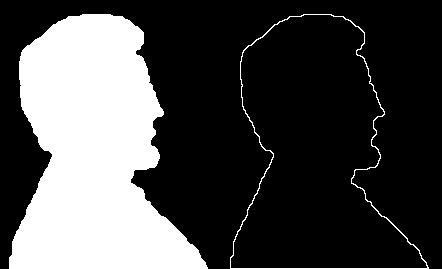

In [13]:
lincoln = read_binary_8bit_img_from_raw_data('data/lincoln.raw', 269, 221)
write_binary_8bit_img_to_raw_data(lincoln - erode(lincoln), 'lincoln_boundary.raw')
lincoln_boundary =  read_binary_8bit_img_from_raw_data('lincoln_boundary.raw', 269, 221)
im.fromarray(np.concatenate(((lincoln*255).astype(np.ubyte), (lincoln_boundary*255).astype(np.ubyte)), axis=1))

Image was written to cktboard_texture.raw


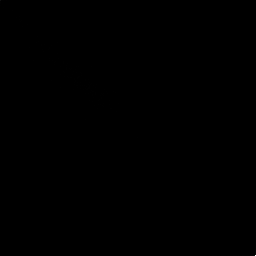

In [14]:
cktboard = read_8bit_img_from_raw_data('data/cktboard.raw', 120, 365)
cktboard_texture = co_occurence(cktboard, (1,0))*40
write_8bit_img_to_raw_data(cktboard_texture, 'cktboard_texture.raw')
cktboard_texture = read_8bit_img_from_raw_data('cktboard_texture.raw', 256, 256)
im.fromarray(cktboard_texture.astype(np.ubyte))

Image was written to fingerprint_opening.raw
Image was written to fingerprint_closing.raw


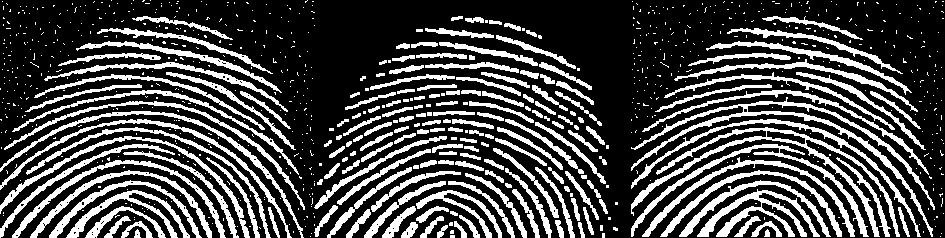

In [15]:
finger_print = read_binary_8bit_img_from_raw_data('data/fingerprint.raw', 238, 315)
write_binary_8bit_img_to_raw_data(opening(finger_print), 'fingerprint_opening.raw')
write_binary_8bit_img_to_raw_data(closing(finger_print), 'fingerprint_closing.raw')
finger_print_opened = read_binary_8bit_img_from_raw_data('fingerprint_opening.raw', 238, 315)
finger_print_closed = read_binary_8bit_img_from_raw_data('fingerprint_closing.raw', 238, 315)
im.fromarray(np.concatenate(((finger_print*255).astype(np.ubyte), (finger_print_opened*255).astype(np.ubyte), (finger_print_closed*255).astype(np.ubyte)), axis=1))